# Hackathon

## Set up notebook

In [103]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from tabulate import tabulate
from tqdm.auto import tqdm

import wandb


In [2]:
sns.set_theme()
plt.rc('figure', figsize=(8, 4), dpi=100)


### Set up Weights & Biases tracking

To make this interesting, we're tracking everyone's progress via W&B. Don't worry 
Please replace `<Your name here>` by your own name (or a nickname).

If you just want to play around without uploading your runs, set `offline` to `True`

In [3]:
# Used for identifying runs on the W&B dashboard
# name = "<Your name here>"
name = "Vincent Brouwers"

# Whether or not to upload runs to W&B
upload = False

# Just for tracking your
run = 0

In [98]:
if name == "<Your name here>":
  raise Exception("RTFM")

## Load Data

In [99]:
# run += 1

In [100]:
df = pd.read_csv("datasets/full.csv")
all_feature_names = df.iloc[:, 1:].columns.to_list()

# class Dataset:
#   """
#   Just a small wrapper to emulate around Scikit-learn's built-in datasets
#   """
#   def __init__(self, df):
#     data = df.iloc[:, 1:]
#     target = df.iloc[:, 0]
#     self.data = data.to_numpy()
#     self.target = target.to_numpy()
#     self.feature_names = data.columns.to_list()    
#     self.target_names = ["not buggy", "buggy"]
    
# data = Dataset(df)

X = df.iloc[:, 1:].to_numpy()
y = df.iloc[:, 0].to_numpy()
feature_names = df.iloc[:, 1:].columns.to_list()    
labels = ["not buggy", "buggy"]

In [7]:
# Split data into 70% train and 30% test subsets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    shuffle=True,
)

In [8]:
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

## Defining our models

The value of features can differ greatly between models, which is why we test across a number of common and easy-to-train ones. We also look at the effect of regularization, as this can also affect the impact of feature selection.

* Decision Tree
* Random Forrest
* Logistic Regression
* Logistic Regression (with L1 regularization)
* Logistic Regression (with L2 regularization)


_There is no need to change anything here. These are just helper functions to quickly test our data_

In [117]:
classifiers = [
        (DecisionTreeClassifier(), ),
        (RandomForestClassifier(n_estimators=200, min_samples_leaf=10, max_depth=20, class_weight="balanced"), ),
        # (SVC(gamma="auto", probability=True, class_weight=class_weight), ),
        (LogisticRegression(max_iter=1000, class_weight="balanced"), ),
        (LogisticRegression(max_iter=1000, penalty="l1", solver="liblinear", class_weight="balanced"), "_l1"),
        (LogisticRegression(max_iter=1000, penalty="l2", class_weight="balanced"), "_l2"),
        (KNeighborsClassifier(n_neighbors=15), )
    ]
classifiers = [(c[0], c[0].__class__.__name__ + (c[1] if len(c) > 1 else "")) for c in classifiers]

In [118]:
baseline = None

def test_classifier(clf, feature_indices):
    if feature_indices is None or len(feature_indices) == 0:
        feature_indices = list(range(X_train.shape[1]))
    clf.fit(X_train[:, feature_indices], y_train)

    # predicted = clf.predict(X_test)
    y_probas = clf.predict_proba(X_test[:, feature_indices])
    y_pred = y_probas.argmax(axis=1)

    scores = {
        f"Accuracy": metrics.accuracy_score(y_test, y_pred),
        f"F1": metrics.f1_score(y_test, y_pred),
        f"Precision": metrics.precision_score(y_test, y_pred),
        f"Recall": metrics.recall_score(y_test, y_pred),
    }
    return scores, y_probas
  
def test_selection(feature_indices, compare=True, log=True, log_wandb=False):
    kwargs = dict(feature_indices=feature_indices, log=False, log_wandb=False)
    
    scores = {}
    table_rows = []
    for classifier, name in tqdm(classifiers, smoothing=0):
        scores_ = test_classifier(classifier, feature_indices=feature_indices)[0]
        scores[name] = scores_
        
        row = [name]
        row += [f"{s:0.4f}" + (f"{baseline[name][m]:0.4f}" if compare else "") for m, s in scores_.items()]
        
        table_rows.append(row)        

    # for n_score, b_score in zip(scores, baseline or range(len(scores))):

    #     if compare:
    #         print(n_score)
    #         print(b_score)
    #         n_score = [f"{n:0.4f} ({n - b:.04f})" for n, b in zip(n_score, b_score)]
                    
    #     table.append([name, *n_score])
    # return table
    # print(table)
    # print(tabulate(table, headers=["Classifier", "Accuracy", "F1", "Precision", "Recall"]))   
    # tabulate(table, headers="key")
    print(tabulate(table_rows, headers=["Classifier", *scores_.keys()]))
    
        
    return scores    

In [119]:
def test_classifier(clf, feature_indices):
    if feature_indices is None or len(feature_indices) == 0:
        feature_indices = list(range(X_train.shape[1]))
    clf.fit(X_train[:, feature_indices], y_train)

    # predicted = clf.predict(X_test)
    y_probas = clf.predict_proba(X_test[:, feature_indices])
    y_pred = y_probas.argmax(axis=1)

    scores = {
        f"Accuracy": metrics.accuracy_score(y_test, y_pred),
        f"F1": metrics.f1_score(y_test, y_pred),
        f"Precision": metrics.precision_score(y_test, y_pred),
        f"Recall": metrics.recall_score(y_test, y_pred),
    }
    return scores, y_probas
  
def test_selection(feature_indices, compare=None, log=True, log_wandb=False):
    kwargs = dict(feature_indices=feature_indices, log=False, log_wandb=False)
    
    scores = {}
    table = []
    for classifier, name in tqdm(classifiers, smoothing=0):
        scores_ = test_classifier(classifier, feature_indices=feature_indices)[0]
        scores[name] = scores_
        
        row = {m: f"{s:0.4f}" + (f" ({s - compare[name][m]:0.4f})" if compare else "") for m, s in scores_.items()}
        row = {"Classifier": name, **row}
        # fmt = {metric: f"{score:0.4f}" for metric, score in scores_.items()}
        table.append(row)
        
        for metric, score in scores_.items():
            rep = f"{score:0.4f}"
            if compare:
                rep += f" ({compare[name][metric]:0.4f})"

    print(tabulate(table, headers="keys"))
        
    return scores    

def test_selector(selector):
    used_features = selector.get_support()
    used_feature_names = selector.get_feature_names_out(data.feature_names)
    print(f"Selected {sum(used_features)}/{len(feature_names)} features: \n{used_feature_names}")

    test_selection(used_features, compare=baseline)
    

## Feature Selection

### Filtering methods

In [120]:
baseline = test_selection(None, compare=False)

  0%|          | 0/6 [00:00<?, ?it/s]

Classifier                Accuracy      F1    Precision    Recall
----------------------  ----------  ------  -----------  --------
DecisionTreeClassifier      0.7659  0.6029       0.6714    0.5471
RandomForestClassifier      0.7627  0.6517       0.6227    0.6835
LogisticRegression          0.7616  0.5854       0.6727    0.5182
LogisticRegression_l1       0.7611  0.5837       0.6724    0.5157
LogisticRegression_l2       0.7616  0.5854       0.6727    0.5182
KNeighborsClassifier        0.7681  0.5769       0.7079    0.4868


#### Variance threshold

A simple method to filter out superfluous features, is to remove ones with a low variance. The idea here is that these features offer relatively little information.

---

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html

In [121]:
from sklearn.feature_selection import VarianceThreshold

var = VarianceThreshold(threshold=0.3).fit(X_train)

test_selector(var)

Selected 19/23 features: 
['h1' 'h2' 'N1' 'N2' 'complexity' 'loc' 'lloc' 'sloc' 'comments' 'multi'
 'blank' 'single_comments' 'no_of_files' 'no_of_added_files'
 'no_of_added_python_files' 'no_of_modified_files'
 'no_of_modified_python_files' 'no_of_deleted_files'
 'no_of_deleted_python_files']


  0%|          | 0/6 [00:00<?, ?it/s]

Classifier              Accuracy          F1                Precision         Recall
----------------------  ----------------  ----------------  ----------------  ----------------
DecisionTreeClassifier  0.7656 (-0.0003)  0.6041 (0.0012)   0.6693 (-0.0021)  0.5504 (0.0033)
RandomForestClassifier  0.7640 (0.0013)   0.6530 (0.0013)   0.6251 (0.0024)   0.6835 (0.0000)
LogisticRegression      0.7611 (-0.0005)  0.5841 (-0.0013)  0.6720 (-0.0007)  0.5165 (-0.0017)
LogisticRegression_l1   0.7613 (0.0003)   0.5840 (0.0003)   0.6731 (0.0007)   0.5157 (0.0000)
LogisticRegression_l2   0.7611 (-0.0005)  0.5841 (-0.0013)  0.6720 (-0.0007)  0.5165 (-0.0017)
KNeighborsClassifier    0.7670 (-0.0011)  0.5770 (0.0001)   0.7031 (-0.0048)  0.4893 (0.0025)


#### Statistical corrolation threshold

Another method of supervised feature filtering is to calculate corrolation statistics between each feature and the label(s). 

We use the chi-squared test to measure the label's (positive) dependence on features and select the best ones with various thresholding methods.

---

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html<br/>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html

In [128]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, r_regression, mutual_info_classif

# Select (k=)10 most corrolated features 
selector = SelectKBest(chi2, k=10).fit(X_train, y_train)

# Select the features that hit the 50th percentile (median score or better)
# selector = SelectPercentile(chi2, percentile=50).fit(X_train, y_train)

test_selector(selector)


Selected 10/23 features: 
['complexity' 'loc' 'sloc' 'no_of_files' 'no_of_added_python_files'
 'no_of_modified_files' 'no_of_modified_python_files'
 'no_of_copied_python_files' 'no_of_deleted_files'
 'no_of_deleted_python_files']


  0%|          | 0/6 [00:00<?, ?it/s]

Classifier              Accuracy          F1                Precision         Recall
----------------------  ----------------  ----------------  ----------------  ----------------
DecisionTreeClassifier  0.7654 (-0.0005)  0.5757 (-0.0272)  0.6976 (0.0262)   0.4901 (-0.0570)
RandomForestClassifier  0.7538 (-0.0089)  0.6439 (-0.0078)  0.6073 (-0.0154)  0.6851 (0.0017)
LogisticRegression      0.7576 (-0.0040)  0.5686 (-0.0169)  0.6738 (0.0011)   0.4917 (-0.0264)
LogisticRegression_l1   0.7576 (-0.0035)  0.5686 (-0.0152)  0.6738 (0.0014)   0.4917 (-0.0240)
LogisticRegression_l2   0.7576 (-0.0040)  0.5686 (-0.0169)  0.6738 (0.0011)   0.4917 (-0.0264)
KNeighborsClassifier    0.7689 (0.0008)   0.5790 (0.0021)   0.7090 (0.0010)   0.4893 (0.0025)


In [123]:
selector

SelectKBest(score_func=<function chi2 at 0x7fbb176e9360>)

#### Model-specific feature importance

Some models allow us to directly see the contribution of each feature. This allows us to easily remove the fields that our model extracts the least amount of information from. We always test the effect our selection methods on multiple model types. Does te type of reference model the model affect our testing models differently?

---

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html

Selected 5/23 features: 
['N1' 'complexity' 'no_of_added_python_files' 'no_of_deleted_python_files'
 'author_previous_commits']


  0%|          | 0/6 [00:00<?, ?it/s]

Classifier              Accuracy          F1                Precision         Recall
----------------------  ----------------  ----------------  ----------------  ----------------
DecisionTreeClassifier  0.7259 (-0.0400)  0.3468 (-0.2561)  0.7677 (0.0963)   0.2240 (-0.3231)
RandomForestClassifier  0.7101 (-0.0526)  0.4187 (-0.2330)  0.6003 (-0.0224)  0.3215 (-0.3620)
LogisticRegression      0.6958 (-0.0658)  0.4126 (-0.1728)  0.5535 (-0.1192)  0.3289 (-0.1893)
LogisticRegression_l1   0.6958 (-0.0652)  0.4126 (-0.1711)  0.5535 (-0.1189)  0.3289 (-0.1868)
LogisticRegression_l2   0.6958 (-0.0658)  0.4126 (-0.1728)  0.5535 (-0.1192)  0.3289 (-0.1893)
KNeighborsClassifier    0.7184 (-0.0497)  0.3646 (-0.2123)  0.6825 (-0.0254)  0.2488 (-0.2380)


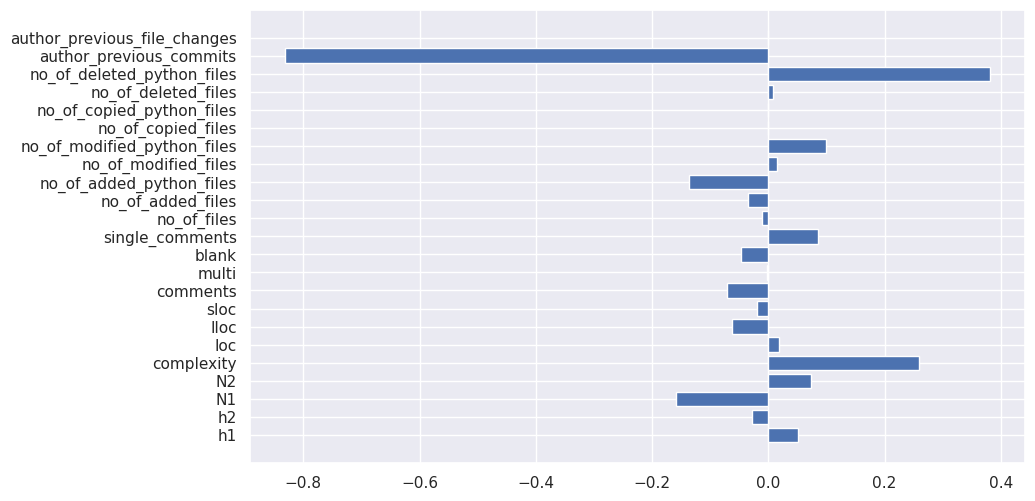

In [125]:
from sklearn.feature_selection import SelectFromModel

plt.figure(figsize=(10, 6))

# clf1 = RandomForestClassifier(n_estimators=200).fit(X_train, y_train)
# plt.barh(feature_names, clf1.feature_importances_)
# selector = SelectFromModel(clf1, threshold="1.5 * mean", prefit=True)

clf2 = LogisticRegression(max_iter=1000).fit(X_train, y_train)
plt.barh(feature_names, clf2.coef_.flatten())
selector = SelectFromModel(clf2, threshold="1 * mean", prefit=True)


test_selector(selector)

### Wrapper

#### Recursive Feature Elimination (RFE)


RFE works in a similar fashion as the previous method, namely that it uses a model's built-in feature significance values to filter out redundant features. Where RFE differs from the "naive" filtering aproach, is that it only removes one feature at a time, after which the entire model is retrained again. Removal of corrolated or inter-dependent features can change the distribution of significance of the remaining features, which this approach mitigates.


---

**Example:**

A simple example of how the result of RFE differs from "naive filtering", is when two features are 100% corrolated. Each of them may be fairly meaningful on their own, though when they're both present, their contribution has to be shared between them. This thus gives them a lower feature importance. 

Let's say we have a model with the following feature importances:

`a=15%`, `b=20%`, `c=50%`, `d=15%`, where `a`, `b` , and `c` are fully independent of eachother, but `d` is 100% corrolated to `a`. 

Naïvely removing the two least contributing features, would leave us with `b=35%` and `c=65%`. If we instead first eliminate `c` (`a` is equally valid), a new model might give us these importances:

`a=30%`, `b=20%`, `c=50%`

This time, `b` will be purged, leaving us with

`a=40%`, `c=60%`

---

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html


In [126]:
from sklearn.feature_selection import RFE

clf = LogisticRegression(max_iter=1000)
selector = RFE(clf, n_features_to_select=5, step=1, verbose=1)
selector = selector.fit(X_train, y_train)

test_selector(selector)

Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Selected 5/23 features: 
['complexity' 'no_of_added_python_files' 'no_of_modified_python_files'
 'no_of_deleted_python_files' 'author_previous_commits']


  0%|          | 0/6 [00:00<?, ?it/s]

Classifier              Accuracy          F1                Precision         Recall
----------------------  ----------------  ----------------  ----------------  ----------------
DecisionTreeClassifier  0.7702 (0.0043)   0.5442 (-0.0587)  0.7650 (0.0936)   0.4223 (-0.1248)
RandomForestClassifier  0.7474 (-0.0153)  0.6045 (-0.0472)  0.6151 (-0.0077)  0.5942 (-0.0893)
LogisticRegression      0.7616 (0.0000)   0.5569 (-0.0285)  0.7028 (0.0300)   0.4612 (-0.0570)
LogisticRegression_l1   0.7616 (0.0005)   0.5569 (-0.0268)  0.7028 (0.0304)   0.4612 (-0.0545)
LogisticRegression_l2   0.7616 (0.0000)   0.5569 (-0.0285)  0.7028 (0.0300)   0.4612 (-0.0570)
KNeighborsClassifier    0.7710 (0.0030)   0.5436 (-0.0333)  0.7709 (0.0629)   0.4198 (-0.0669)


#### Sequential Feature Selection

This Sequential Feature Selector adds (forward selection) or removes (backward selection) features until the desired amount of features is reached. At each stage, it produces candidate feature sets that include (forward) or exclude (backward) one feature compared to the previous stage. The candidate sets are scored by training new models on them and only the best scoring one is kept.

Forwards and backwards do not have to yield the same feature sets, though none is necessarily better. Their performance can differ depending on the amount and size of models that need to be trained to reach the desired amount of features.

---

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html

In [132]:
from sklearn.feature_selection import SequentialFeatureSelector

direction = "forward"
# direction = "backward"

clf = LogisticRegression(max_iter=1000)
selector = SequentialFeatureSelector(clf, n_features_to_select=15, direction=direction, scoring="f1", n_jobs=-1)

selector = selector.fit(X_train, y_train)

test_selector(selector)

Selected 15/23 features: 
['h2' 'complexity' 'lloc' 'comments' 'multi' 'blank' 'single_comments'
 'no_of_files' 'no_of_added_files' 'no_of_added_python_files'
 'no_of_modified_python_files' 'no_of_copied_files'
 'no_of_copied_python_files' 'no_of_deleted_python_files'
 'author_previous_commits']


  0%|          | 0/6 [00:00<?, ?it/s]

Classifier              Accuracy          F1                Precision         Recall
----------------------  ----------------  ----------------  ----------------  ----------------
DecisionTreeClassifier  0.7697 (0.0038)   0.5945 (-0.0084)  0.6943 (0.0229)   0.5198 (-0.0273)
RandomForestClassifier  0.7485 (-0.0142)  0.6386 (-0.0131)  0.5987 (-0.0240)  0.6843 (0.0008)
LogisticRegression      0.7613 (-0.0003)  0.5844 (-0.0010)  0.6728 (0.0000)   0.5165 (-0.0017)
LogisticRegression_l1   0.7613 (0.0003)   0.5844 (0.0007)   0.6728 (0.0004)   0.5165 (0.0008)
LogisticRegression_l2   0.7613 (-0.0003)  0.5844 (-0.0010)  0.6728 (0.0000)   0.5165 (-0.0017)
KNeighborsClassifier    0.7699 (0.0019)   0.5683 (-0.0086)  0.7277 (0.0198)   0.4661 (-0.0207)


### Own selection

Now try it for yourself. Is there another method of feature selection you would like to try? Do yo think combining other methods might 

In [ ]:
used_features = selector.get_support()
used_feature_names = selector.get_feature_names_out(data.feature_names)
print(f"Selected {sum(used_features)}/{len(feature_names)} features: \n{used_feature_names}")

test_selection(used_features, compare=baseline)
None

In [ ]:
# %%wandb

# run += 1

# used_features = [[name, name in all_feature_names] for name in data.feature_names]
used_features = {name: name in data.feature_names for name in all_feature_names}

wandb.init(
    project="sogeti-hackathon-feature-selection",
    entity="vincentbrouwers",
    name=f"{name}-run {run}",
    anonymous="allow",
    tags=dict(name=name, run=run),
    mode="online" if upload else "offline",
    config=dict(features=used_features)
)

y_probas = clf.predict_proba(X_test)
y_pred = y_probas.argmax(axis=1)    

# wandb.log(
#     {
#         "conf_mat": wandb.plot.confusion_matrix(
#             y_probas, y_test, class_names=data.target_names
#         )
#     }
# )
# wandb.log()
wandb.log(
    {
        "feature_count": len(data.feature_names),
        "used_features": wandb.Table(
            columns=["feature", "used"],
            # Just temporary until I have an actual method of filtering features
            data=list(used_features.items()),
        ),
        "roc": wandb.plot.roc_curve(y_test, y_probas, data.target_names),
        "pr": wandb.plot.pr_curve(y_test, y_probas, data.target_names),
    }
)

wandb.finish()


feature_count,▁
feature_count,19


## Test your solution

At the end of the hackathon, you will all receive a withheld test set to test your solutions on. You will be scored on how many features you use and the accuracy difference of our models after training on your reduced feature set.